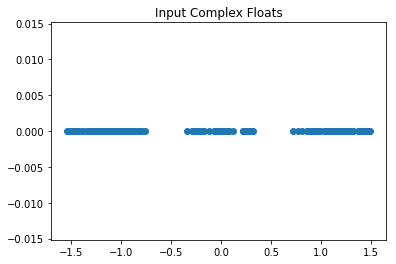

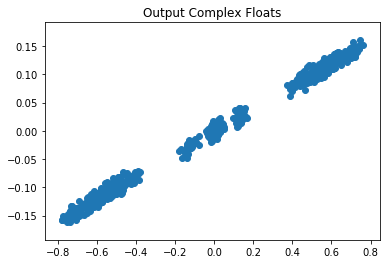

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

def complexSignals(inFile, outFile):
    BytesIn = np.fromfile(inFile, dtype = 'uint8')
    floatsIn = np.fromfile(inFile, dtype = 'float32')
    complexIn = np.array([complex(floatsIn[2*i], floatsIn[2*i + 1]) for i in range(len(floatsIn) // 2)])
    BitsIn = np.unpackbits(BytesIn)

    floatsOut = np.fromfile(outFile, dtype = 'float32')
    complexOut = np.array([complex(floatsOut[2*i], floatsOut[2*i + 1]) for i in range(len(floatsOut) // 2)])
    BytesOut = np.fromfile(outFile, dtype = 'uint8')
    BitsOut = np.unpackbits(BytesOut)
    
    return complexIn, complexOut

def plot(complexIn, complexOut):
    plt.scatter(complexIn.real, complexIn.imag)
    plt.title("Input Complex Floats")
    plt.show()
    plt.clf()

    plt.scatter(complexOut.real, complexOut.imag)
    plt.title("Output Complex Floats")
    plt.show()
    plt.clf()
    
inFile = 'dumpfiles/input_complex_noiseless_original'
outFile = 'dumpfiles/output_complex_noiseless'
complexIn, complexOut = complexSignals(inFile, outFile)
plot(complexIn, complexOut)

In [75]:
def correlate(complexIn, complexOut, samples):
    result = np.correlate(complexIn[:samples], complexIn[:samples], mode='full')
    autoCorrIn = np.sqrt(result[result.size//2:][0])
    crossCorArray = [np.correlate(complexIn[:samples], complexOut[start: start + samples]) / np.sqrt(np.correlate(complexOut[start: start + samples], complexOut[start: start + samples]))
                     for start in range(len(complexOut) - samples + 1)] / autoCorrIn
    maxCrossCor = max(crossCorArray) 
    lag = np.argmax(crossCorArray)
    maxCorrOutput = complexOut[lag: lag + samples]
    
    return lag, maxCrossCor, crossCorArray, maxCorrOutput
    

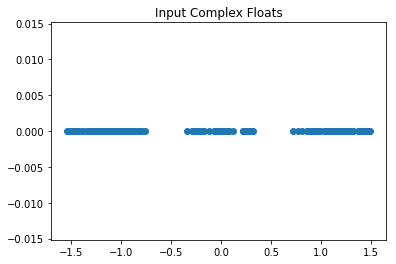

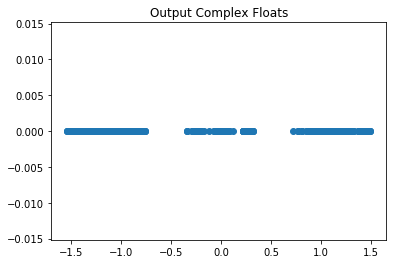

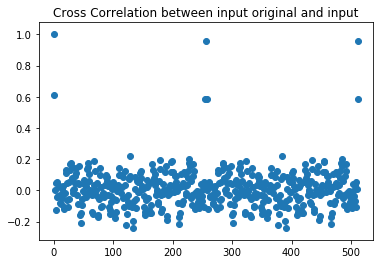

In [78]:
inFile = 'dumpfiles/input_complex_noiseless_original'
outFile = 'dumpfiles/input_complex_noiseless'
complexIn, complexOut = complexSignals(inFile, outFile)
plot(complexIn, complexOut)

lag, maxCrossCor, corrArray, maxCorrOutput = correlate(complexIn, complexOut, len(complexIn))
plt.scatter(np.arange(len(corrArray)), corrArray)
plt.title("Cross Correlation between input original and input")
plt.show()

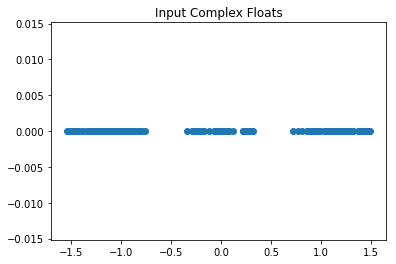

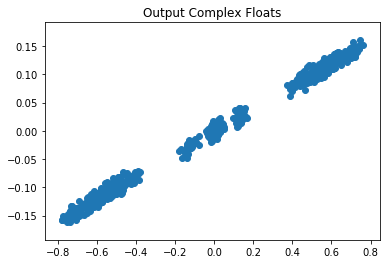

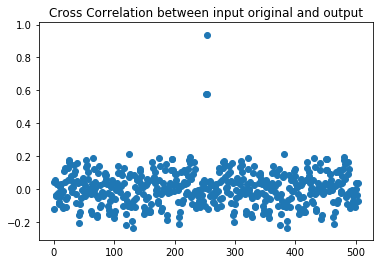

In [79]:
inFile = 'dumpfiles/input_complex_noiseless_original'
outFile = 'dumpfiles/output_complex_noiseless'
complexIn, complexOut = complexSignals(inFile, outFile)
plot(complexIn, complexOut)

lag, maxCrossCor, corrArray, maxCorrOutput = correlate(complexIn, complexOut, len(complexIn))
plt.scatter(np.arange(len(corrArray)), corrArray)
plt.title("Cross Correlation between input original and output")
plt.show()

In [126]:
import numpy.linalg

def constructMatrix(complexIn, numTaps):
    matrix = []
    for i in range(len(complexIn) - numTaps + 1):
        matrix.append(complexIn[i: i + numTaps])
        
    return np.matrix(matrix)

def bestEstimator(X, y, l=0.1):
    # Returns the best estimator in ridge regression
    XTX = X.T.dot(X)
    ridge = XTX + l*np.identity(XTX.shape[0])
    rhs = X.T.dot(y)
    return np.linalg.solve(ridge, rhs)

def iterativeBestEstimator(complexIn, maxCorrOutput):
    numTaps = 1
    while True:
        inputMatrix = constructMatrix(complexIn, numTaps)
        ynew = np.array(maxCorrOutput[:inputMatrix.shape[0]]).reshape((-1, 1))
        tapsOld = bestEstimator(inputMatrix, ynew)
        oldError = np.linalg.norm(inputMatrix.dot(tapsOld) - ynew)
        inputMatrix = constructMatrix(complexIn, numTaps + 1)
        ynew = np.array(maxCorrOutput[:inputMatrix.shape[0]]).reshape((-1, 1))
        tapsNew = bestEstimator(inputMatrix, ynew)
        newError = np.linalg.norm(inputMatrix.dot(tapsNew) - ynew)
        if newError > oldError:
            return tapsOld, numTaps
        numTaps += 1


In [129]:
inFile = 'dumpfiles/input_complex_noiseless_original'
outFile = 'dumpfiles/output_complex_noiseless'
complexIn, complexOut = complexSignals(inFile, outFile)

# ACTUAL: 0.5 + 0.1j
lag, maxCrossCor, corrArray, maxCorrOutput = correlate(complexIn, complexOut, len(complexIn))
inputMatrix = constructMatrix(complexIn, numTaps=1)
bestEstimator(inputMatrix, np.array(maxCorrOutput[:inputMatrix.shape[0]]).reshape((-1, 1)))
iterativeBestEstimator(complexIn, maxCorrOutput)

matrix([[ 0.49990394+0.09970856j]])

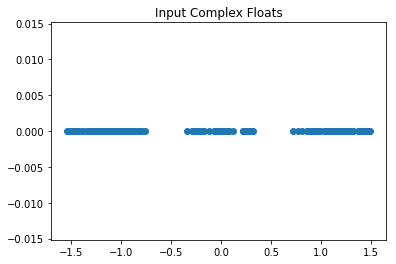

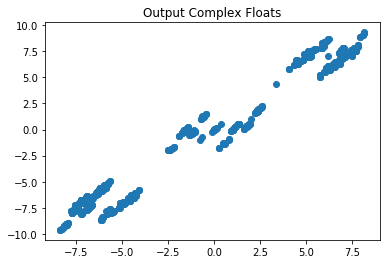

matrix([[ 6.30919771+6.38068604j],
        [-1.31960168-0.26046507j],
        [ 0.79765945+0.19217823j]])

In [133]:
inFile = 'dumpfiles/input_complex_noiseless_original'
outFile = 'dumpfiles/output_complex_noiseless_3-1dominant'
complexIn, complexOut = complexSignals(inFile, outFile)
plot(complexIn, complexOut)

# ACTUAL: 5.0 + 6.1j, 0.8 + 0.2j, 0.7 + 0.05 j
lag, maxCrossCor, corrArray, maxCorrOutput = correlate(complexIn, complexOut, len(complexIn))
inputMatrix = constructMatrix(complexIn, numTaps=3)
bestEstimator(inputMatrix, np.array(maxCorrOutput[:inputMatrix.shape[0]]).reshape((-1, 1)))
iterativeBestEstimator(complexIn, maxCorrOutput)

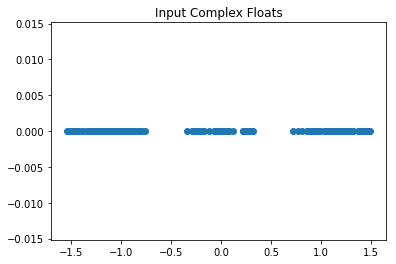

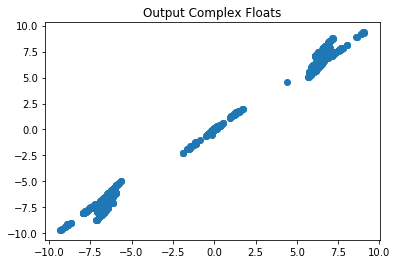

[[ 5.92650071+6.16317734j]
 [-0.01509533+0.14085338j]
 [ 0.46532695+0.08306225j]]


(matrix([[ 6.56765708+6.10502896j],
         [-1.55859879+0.20376958j],
         [ 2.47410337-0.02782392j],
         [-1.68207047+0.07249778j],
         [ 0.45752707-0.01760899j],
         [ 0.57699001-0.01694913j],
         [-0.99906471-0.07588471j],
         [ 0.53494067+0.02342322j],
         [-0.01034449-0.16630916j],
         [-0.52828095+0.0276685j ],
         [ 0.37156514-0.04179046j],
         [-0.20438295-0.22712713j],
         [-0.40482660-0.0562223j ],
         [ 0.17220534-0.16064071j],
         [-0.11190040-0.06796036j],
         [-0.21819933+0.03469122j],
         [ 0.20331096-0.05580021j],
         [-0.15473365-0.11613086j],
         [ 0.09821642+0.27020882j],
         [ 0.21822479+0.02045064j],
         [-0.08457900-0.06397786j],
         [ 0.14512442+0.2589061j ],
         [ 0.25405022+0.15748372j],
         [ 0.01717403+0.04192295j],
         [ 0.01263966+0.05646677j],
         [ 0.09994617+0.02077058j],
         [-0.03775225-0.02941104j],
         [ 0.02408670+0.0453

In [138]:
inFile = 'dumpfiles/input_complex_noiseless_original'
outFile = 'dumpfiles/output_complex_noiseless_3-1dominant_shuffle'
complexIn, complexOut = complexSignals(inFile, outFile)
plot(complexIn, complexOut)

# ACTUAL: 0.8 + 0.2j, 5.0 + 6.1j, 0.7 + 0.05 j
lag, maxCrossCor, corrArray, maxCorrOutput = correlate(complexIn, complexOut, len(complexIn))
inputMatrix = constructMatrix(complexIn, numTaps=3)
print(bestEstimator(inputMatrix, np.array(maxCorrOutput[:inputMatrix.shape[0]]).reshape((-1, 1))))
iterativeBestEstimator(complexIn, maxCorrOutput)

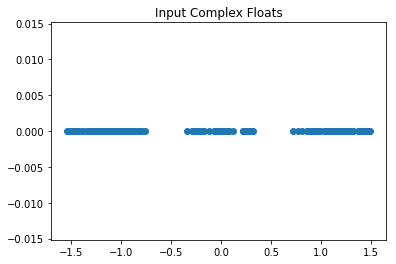

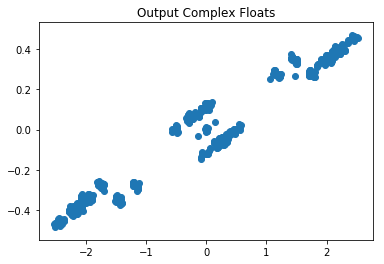

[[ 1.72572083+0.26658364j]
 [-0.31131947+0.04161779j]
 [ 0.42535563+0.03312155j]]


(matrix([[ 2.45215154+0.31877016j],
         [-2.08980582-0.08715963j],
         [ 3.05824949+0.22578785j],
         [-2.80537507-0.20860379j],
         [ 2.04744910+0.15749915j],
         [-1.17417008-0.09455776j],
         [ 0.49302587+0.0432962j ],
         [-0.15255792-0.01636131j]]), 8)

In [139]:
inFile = 'dumpfiles/input_complex_noiseless_original'
outFile = 'dumpfiles/output_complex_noiseless_3eq'
complexIn, complexOut = complexSignals(inFile, outFile)
plot(complexIn, complexOut)

# ACTUAL: 0.5 + 0.1j, 0.8 + 0.2j, 0.7 + 0.05 j
lag, maxCrossCor, corrArray, maxCorrOutput = correlate(complexIn, complexOut, len(complexIn))
inputMatrix = constructMatrix(complexIn, numTaps=3)
print(bestEstimator(inputMatrix, np.array(maxCorrOutput[:inputMatrix.shape[0]]).reshape((-1, 1))))
iterativeBestEstimator(complexIn, maxCorrOutput)